In [1]:
import itertools
import os.path as op
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import scipy.signal as sp
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import os
import pickle
import warnings
import seaborn as sns
from scipy.special import iv
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')

wlsubj = 114

proj_dir = "//Users/rob/mnt/winawer/Projects/Interstellar" #'/Volumes/server/Projects/Spatial_Memory_RW/'
prf_dir = "//Users/rob/mnt/winawer/Projects/Retinotopy_NYU_3T/derivatives/prfanalyze-vista/sub-wlsubj%03d/ses-nyu3t01" 
glm_dir = "//Users/rob/Documents/Research/Interstellar/code/GLMsingle/sub-wlsubj%03d" 

data_dir = op.join(proj_dir, 'data')
df_dir = op.join(data_dir, 'dataframes')

subjects = ['wlsubj127']
ret_params = ['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'ROIs_V1-3']
models = ['saccade', 'nosaccade']
design = {'perception':'loc', 'memory':'loc'}
hrfmodels = {'perception':'optimize', 'memory':'optimize'}
space = 'surf'
load_hemis = ['lh', 'rh']
hemis = ['lh', 'rh', 'b']
rois = ['V1', 'V2', 'V3', 'hV4', 'LO', 'V3ab']
roi_suff = '_hand'

subject = 1
i = 1
stimdur = 11.5
tr = 1

cbi_path = "//Users/rob/mnt/winawer/Projects/Interstellar"
data_path = op.join(cbi_path, 'derivatives/fmriprep/sub-wlsubj%03d/ses-nyu3t01/func' % wlsubj)

design_file = '//Users/rob/mnt/winawer/Projects/Interstellar/design/sub-001/sub-001_designTrial.tsv'


## Helper Functions

In [21]:
def load_retinotopy(subj_prf_directory, load_hemis, ret_params):
    ret = {p:{'lh':[], 'rh':[]} for p in ret_params}

    for hemi, param in itertools.product(load_hemis, ret_params):
        rfile = glob.glob(op.join(subj_prf_directory, '%s*%s.mgz') % (hemi, param))
        r = nib.load(rfile[0]).get_fdata().squeeze()
        ret[param][hemi].append(r)
    
    for param in ret_params:
        ret[param]['b'] = [np.concatenate(b) for b in zip(ret[param]['lh'], ret[param]['rh'])]
        
    return ret


def load_glmsingle(filename, params = ''):
    g = np.load(filename, allow_pickle = True).item()
    
    if params == 'all':
        gparams = dict()
        for p, values in g.items():
            gparams[p] = g[p]
            
    elif params:
        gparams = dict()
        for p in params:
            gparams[p] = g[p]          
    else:
        gparams = {
            'beta': g['betasmd'],
            'R2': g['R2'],
            'se': g['glmbadness'],
            'rse': g['rrbadness']
        }

    return gparams


def get_trialconds(wlsubj):
    sub_dir = '../designs/sub-wlsubj%03d/' % wlsubj
    filenames = os.listdir(sub_dir)
    filenames.sort()
    design = []
    for f in filenames:
        design.append(np.load(op.join(sub_dir, f)))
        
        
    con_dir = '//Users/rob/mnt/winawer/Projects/Interstellar/task/Interstellar/pilot/design/sub-wlsubj%03d/' % wlsubj
    sample_filename = os.listdir(con_dir)[0]
    trials = pd.read_csv(op.join(con_dir, sample_filename), sep = '\t')
    conds = trials.gratingAng.unique()
    conds.sort()
        
    return conds, design


def sort_trials(design):
    conditions = []
    for d in design:
        conditions.append(np.where(d == 1)[1])
        
    conditions = np.concatenate(conditions)
    
    return conditions


def fix_deg(x):
    x = x - np.floor(x / 360 + 0.5) * 360
    
    return x


def voxels_df(ret, betas, n_vox, rois = [], hemi = 'b', stim_ecc = 7, sd_ecc = True):
    # Pull retinotopy data
    voxels = {
        'x': ret['x'][hemi][0][:n_vox],
        'y': ret['y'][hemi][0][:n_vox],
        'eccen': ret['eccen'][hemi][0][:n_vox],
        'angle': ret['angle'][hemi][0][:n_vox],
        'sigma': ret['sigma'][hemi][0][:n_vox],
        'vexpl': ret['vexpl'][hemi][0][:n_vox],
        'roi': ret['ROIs_V1-3'][hemi][0][:n_vox]
    }
    
    # Pull betas for each condition
    # for c in range(len(conds)):
    #     b = betas[:n_vox, c].squeeze()
    #     voxels['c'+ str(c)] = b

    voxels = pd.DataFrame(voxels)
    voxels = pd.DataFrame(betas).join(voxels)
    
    
    # Filter by ROIs and restrict eccentricity
    if rois:
        voxels = voxels[voxels.roi.isin(rois)]
        
    if sd_ecc:
        voxels = voxels[np.abs(stim_ecc - voxels.eccen) <= voxels.sigma]
        
    
    #  Calculate angular distance of voxels pref angle to each cond angle
    # for i, c in enumerate(conds):
    #     voxels['dist_c%d' % (i)] = np.degrees(voxels.angle) - c
    #     voxels['dist_c%d' % (i)] = voxels['dist_c%d' % (i)].apply(fix_deg)
    
    return voxels


def voxelsMeanCond(voxels, conditions):
    conds = np.unique(conditions)
    conds.sort()
    
    for i, c in enumerate(conds):
        indices = np.where(conditions == c)[0]
        v = voxels.iloc[:, indices]
        voxels_mean = v.mean(axis = 1)
        voxels['cond%02d' % i] = voxels_mean
        
    return voxels


def voxelsAngDist(wlsubj, voxels, angles, save = True):
    for i, angle in enumerate(angles):
        angle = -angle + 90
        angular_dist = np.degrees(voxels.angle) - angle
        angular_dist = angular_dist.apply(fix_deg)
        
        voxels['dist_cond%02d' % i] = angular_dist
        
        if save:
            filename = '../voxels/sub-wlsubj%03d/sub-wlsubj%03d_voxels.npy' % (wlsubj, wlsubj)
            np.save(filename, voxels)
        
    return voxels


def compute_parf(n_bins, angledists, betas):
    bins_idxs = np.degrees(np.linspace(-np.pi, np.pi, n_bins))
    bins = np.stack([bins_idxs[:-1], bins_idxs[1:]], axis = 1)

    parf = np.zeros([len(bins), 2])
    serr = np.zeros([len(bins)])

    for i, b in enumerate(bins):
        idxs = np.where((angledists >= b[0]) & (angledists <= b[1]))
        parf[i] = np.array([np.nanmean(angledists.iloc[idxs]), np.nanmean(betas.iloc[idxs])])
        serr[i] = sem(betas.iloc[idxs])

    return parf, serr


def plot_parf(voxels, conds_idxs, n_bins, rois = [], plot = True):
    if n_bins % 2:
        print("Must use even # of bins")
        raise ValueError("Must use even # of bins")
        
    if rois:
        voxels = voxels.loc[voxels['roi'].isin(rois)]
    
    P = []
    S = []
    FWHM = []
    AMP = []
    peaks = []
    center = int((n_bins - 1)/2)
    
    for c in conds_idxs:
        
        parf, serr = compute_parf(n_bins, voxels["dist_cond%02d" % c], voxels["cond%02d" % c])
        P.append(parf[:, 1])
        S.append(serr)

        tuning_curve = parf[:, 1]
        fwhm, amp, _, _ = sp.peak_widths(tuning_curve, np.array([center]))
        FWHM.append(fwhm)
        AMP.append(amp)
        peaks.append(tuning_curve[center])


    P = np.stack(P).mean(axis = 0)

    x = np.degrees(np.linspace(-np.pi, np.pi, n_bins-1))
                   
    if plot: plt.plot(x, P)
    
    return P, x, S, FWHM, AMP, peaks
                   


def vonmises(theta, loc, kappa, scale):
    p = scale * np.exp(kappa*np.cos(theta-loc))/(2*np.pi*iv(0,kappa))
    return p


def diff_vonmises(theta, loc, kappa1, scale1, kappa2, scale2):
    p1 = vonmises(theta, loc, kappa1, scale1)
    p2 = vonmises(theta, loc, kappa2, scale2)
    return (p1 - p2) 


def fwhm(X, Y):
    d = Y - (max(Y) / 2) 
    indexes = np.where(d > 0)[0] 
    return abs(X[indexes[-1]] - X[indexes[0]])


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    
    return(rho, phi)


def pol2cart(rho, phi):    
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    
    return(x, y)


def rotate_xy(voxels, conds, angle_fix = False, offset = 0):
    rot_voxels = pd.DataFrame(columns = ['x', 'y', 'eccen', 'angle', 'betas'], dtype = float)
    for cond in conds:
        new_voxels = {}
        ang_dists = voxels['dist_cond%02d' % cond]
        
        if angle_fix: ang_dists = -ang_dists + 90
        
        ang_dists += offset
        ang_dists_rads = np.radians(ang_dists)
        x, y = pol2cart(voxels.eccen, ang_dists_rads)

        new_voxels['x'] = x.values
        new_voxels['y'] = y.values
        new_voxels['eccen'] = voxels['eccen'].values
        new_voxels['angle'] = voxels['dist_cond%02d' % cond].values
        new_voxels['betas'] = voxels['cond%02d' % cond].values

        new_voxels = pd.DataFrame.from_dict(new_voxels)

        rot_voxels = rot_voxels.append(new_voxels)


    return rot_voxels


def interpolate_activity(data, conds, angle_fix = False, offset = 0, normalize = False, degs_lim = 8, coords = 'cartesian'):
    # Define stim space grid
    minval, maxval, stepval = [-degs_lim, degs_lim, .125]
    x, y = np.mgrid[minval:maxval:stepval, minval:maxval:stepval]
    
    # Polar
    thetaminval, thetamaxval, thetastepval = [-np.pi, np.pi, .0328]
    rhominval, rhomaxval, rhostepval = [0, degs_lim, 0.125/2]
    py, px = np.mgrid[thetaminval:thetamaxval:thetastepval, rhominval:rhomaxval:rhostepval]
    
    # Log Polar
    lthetaminval, lthetamaxval, lthetastepval = [-np.pi, np.pi, .0328]
    lrhominval, lrhomaxval, lrhostepval = [0, np.log(degs_lim+0.0001), np.log(degs_lim+0.0001)/192]
    ly, lx = np.mgrid[lthetaminval:lthetamaxval:lthetastepval, lrhominval:lrhomaxval:lrhostepval]
    
    
    
    interp_df = []
    # Subset data by condition and rotate
    for i, cond in enumerate(conds):
        ang_dists = data['dist_cond%02d' % i]
        
        if angle_fix: ang_dists = -ang_dists + 90
        
        ang_dists += offset
        ang_dists_rads = np.radians(ang_dists)
        rot_x, rot_y = pol2cart(data.eccen, ang_dists_rads)
        
        data['rot_x'] = rot_x.values
        data['rot_y'] = rot_y.values
        data['theta'] = ang_dists_rads
        data['rho'] = data.eccen
        data['lrho'] = np.log(data.eccen+0.0001)
        
        if coords == 'cartesian':
            pts = data[['x', 'y']].values
            vals = data['cond%02d' % i].values
            sinterp = griddata(pts, vals, (x, y), method = 'linear', rescale = True).T

            pts = data[['rot_x', 'rot_y']].values
            vals = data['cond%02d' % i].values
            sinterp_rot = griddata(pts, vals, (x, y), method = 'linear', rescale = True).T
            
        elif coords == 'polar':
            pts = data[['rho', 'theta']].values
            vals = data['cond%02d' % i].values
            sinterp = griddata(pts, vals, (px, py), method = 'linear', rescale = True)

            pts = data[['rho', 'theta']].values
            vals = data['cond%02d' % i].values
            sinterp_rot = griddata(pts, vals, (px, py), method = 'linear', rescale = True)
            
        elif coords == 'logpolar':
            pts = data[['lrho', 'theta']].values
            vals = data['cond%02d' % i].values
            sinterp = griddata(pts, vals, (lx, ly), method = 'linear', rescale = True)

            pts = data[['lrho', 'theta']].values
            vals = data['cond%02d' % i].values
            sinterp_rot = griddata(pts, vals, (lx, ly), method = 'linear', rescale = True)
        
        if normalize:
            sinterp = (sinterp - np.nanmean(sinterp)) / np.nanstd(sinterp)
            sinterp_rot = (sinterp_rot - np.nanmean(sinterp_rot)) / np.nanstd(sinterp_rot)
            
        if i < (len(conds)/2):
            sacc = 1
        else:
            sacc = 0
            
        sdf = pd.DataFrame(dict(stim_angle = cond, activity_map=sinterp.flatten(), activity_map_rot=sinterp_rot.flatten(), sacc = sacc, inds=np.arange(len(sinterp.flatten()))))
        interp_df.append(sdf)
        
    interp_df = pd.concat(interp_df).reset_index(drop=True)
    
    return interp_df
        

def activity_heatmap(ax_data, g, degs_lim = 8, vmax=1.5):
    n_steps = len(np.arange(-degs_lim, degs_lim, 0.125))
    
    for i, d in enumerate(ax_data):
        ax = g.axes.flatten()[i]
        sns.heatmap(np.reshape(d, (n_steps, n_steps)), cbar=False, square=True, cmap='RdBu_r', 
                    vmin=-1*vmax, vmax=vmax, linewidths=0, cbar_kws={'ticks':[]}, ax=ax)
        ax.invert_yaxis()
        #ax.set(xlim=[-4, 132], ylim=[-4, 132])
        ax.set_xticklabels(labels=[], rotation=0)
        ax.set_yticklabels(labels=[])
        ax.axhline(y=n_steps/2, c="0")
        ax.axvline(x=n_steps/2, c="0")
        ax.text(n_steps+8, n_steps/2, "$\it{x}$", ha='left', va='center', color="0", size=12)
        ax.text(n_steps/2, n_steps+8, "$\it{y}$", ha='center', va='bottom', color="0", size=12)
        ax.text(n_steps/2, n_steps+8, "$\it{y}$", ha='center', va='bottom', color="0", size=12)
        
    sns.despine(trim=True, left=True, bottom=True)
    plt.gcf().tight_layout(h_pad=3)
    
    
def stim_activity_figure(interp_data, vmax=[1.5, 1.5], degs_lim = 8):
    dplot = interp_data.groupby(['stim_angle', 'sacc', 'inds'])['activity_map'].aggregate(np.nanmedian).reset_index()
    with sns.axes_style("white"):
        g = sns.FacetGrid(col = 'stim_angle', height = 3, aspect = 1, sharex=False, data = interp_data)
        
    ax_data = []

    for i, d in g.facet_data():
        s, a = d[['sacc', 'stim_angle']].iloc[0]
        ax_data.append(dplot.query("sacc==@s & stim_angle==@a")['activity_map'].values)

    
    activity_heatmap(ax_data, g, degs_lim = degs_lim, vmax=vmax)
    
    return ax_data
    
    
def avg_activity_figure(interp_data, vmax=1.5, degs_lim = 8):
    
    # Average across subjects 
    dplot = interp_data.groupby(['sacc', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    
    # Create axes and get data for each facet
    with sns.axes_style("white"):
        g = sns.FacetGrid(col='sacc', col_order=[1, 0], 
                         height=3, aspect=1, sharex=False, data=interp_data)
    ax_data = []
    for i, d in g.facet_data():
        s = d['sacc'].iloc[0]
        ax_data.append(dplot.query("sacc==@s")['activity_map_rot'].values)
        
    # Plot heatmap on each facet
    activity_heatmap(ax_data, g, degs_lim = degs_lim, vmax=vmax)

In [14]:
16*8

128

In [24]:
wlsubj = 114

ret = load_retinotopy(prf_dir % wlsubj, load_hemis, ret_params)
gparams = load_glmsingle(op.join(glm_dir % wlsubj, "TYPED_FITHRF_GLMDENOISE_RR.npy"))

betas = gparams['beta']

n_vox = betas.shape[0]
print(betas.shape)

(511173, 1, 1, 128)


8 6.883797340430392 6.867849349975586
8 6.9708396981221545 6.623736619949341
8 6.553747995110119 6.05280613899231


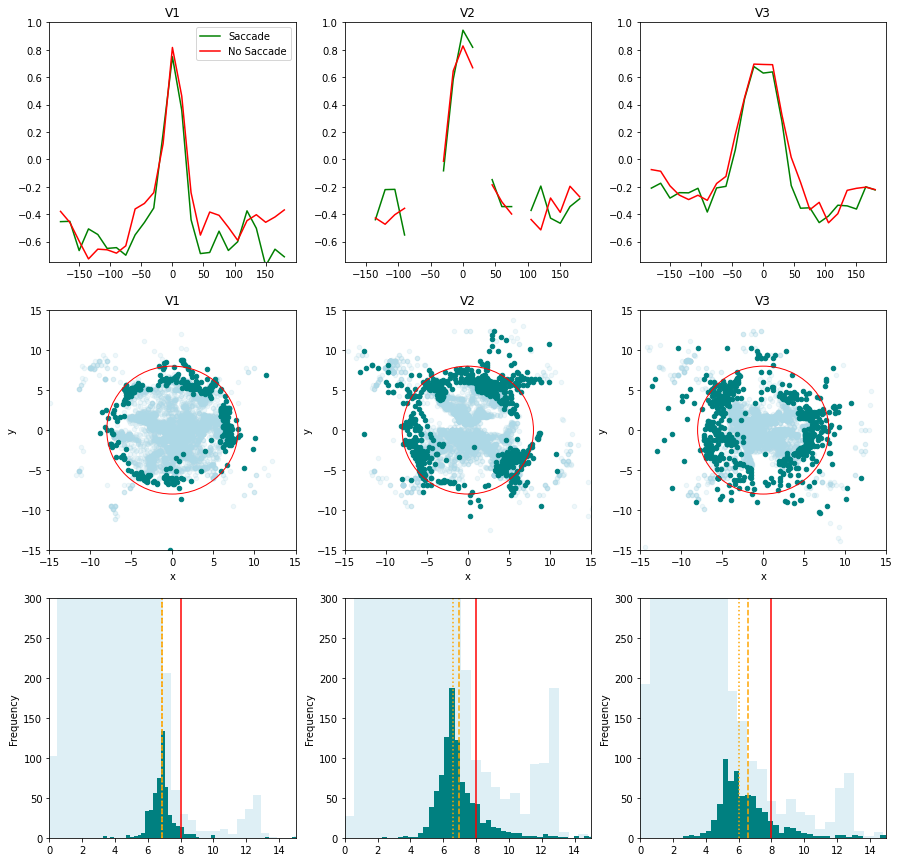

In [87]:
stim_ecc = 8
betas = betas.squeeze()

conds, design = get_trialconds(wlsubj)
conds_by_trials = sort_trials(design)
voxels = voxels_df(ret, betas, n_vox, rois = [1, 2, 3], stim_ecc = stim_ecc)
voxels = voxelsMeanCond(voxels, conds_by_trials)
angles = np.concatenate([conds, conds])
voxels = voxelsAngDist(wlsubj, voxels, angles)

all_voxels = voxels_df(ret, betas, n_vox, rois = [1, 2, 3], stim_ecc = stim_ecc, sd_ecc=False)
all_voxels = voxelsMeanCond(all_voxels, conds_by_trials)
angles = np.concatenate([conds, conds])
all_voxels = voxelsAngDist(wlsubj, all_voxels, angles)

                   
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
n_bins = 26
s_v1, x, _, _, _, _ = plot_parf(voxels, range(16), n_bins, rois = [1], plot = False)
s_v2, x, _, _, _, _ = plot_parf(voxels, range(16), n_bins, rois = [2], plot = False)
s_v3, x, _, _, _, _ = plot_parf(voxels, range(16), n_bins, rois = [3], plot = False)
                   
n_v1, x, _, _, _, _ = plot_parf(voxels, range(16, 32), n_bins, rois = [1], plot = False)
n_v2, x, _, _, _, _ = plot_parf(voxels, range(16, 32), n_bins, rois = [2], plot = False)
n_v3, x, _, _, _, _ = plot_parf(voxels, range(16, 32), n_bins, rois = [3], plot = False)

v1 = voxels.loc[voxels['roi'].isin([1])]
v2 = voxels.loc[voxels['roi'].isin([2])]
v3 = voxels.loc[voxels['roi'].isin([3])]
                   
axs[0, 0].plot(x, s_v1, c = 'green')
axs[0, 0].plot(x, n_v1, c = 'red')
axs[0, 0].set_title('V1')
axs[0, 0].set_ylim([-.75, 1])
axs[0, 0].legend(['Saccade', 'No Saccade'])

axs[0, 1].plot(x, s_v2, c = 'green')
axs[0, 1].plot(x, n_v2, c = 'red')
axs[0, 1].set_ylim([-.75, 1])
axs[0, 1].set_title('V2')

axs[0, 2].plot(x, s_v3, c = 'green')
axs[0, 2].plot(x, n_v3, c = 'red')
axs[0, 2].set_ylim([-.75, 1])
axs[0, 2].set_title('V3')


all_voxels[all_voxels['roi'].isin([1])].plot.scatter('x', 'y', ax = axs[1, 0], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.2, c = 'lightblue')
all_voxels[all_voxels['roi'].isin([2])].plot.scatter('x', 'y', ax = axs[1, 1], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.2, c = 'lightblue')
all_voxels[all_voxels['roi'].isin([3])].plot.scatter('x', 'y', ax = axs[1, 2], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], alpha = 0.2, c = 'lightblue')

v1.plot.scatter('x', 'y', ax = axs[1, 0], title = 'V1', xlim = [-15, 15], ylim = [-15, 15], c = 'teal')
v2.plot.scatter('x', 'y', ax = axs[1, 1], title = 'V2', xlim = [-15, 15], ylim = [-15, 15], c = 'teal')
v3.plot.scatter('x', 'y', ax = axs[1, 2], title = 'V3', xlim = [-15, 15], ylim = [-15, 15], c = 'teal')



ecc_circle1 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)
ecc_circle2 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)
ecc_circle3 = plt.Circle((0, 0), stim_ecc, color='r', fill=False)

axs[1, 0].add_patch(ecc_circle1)
axs[1, 1].add_patch(ecc_circle2)
axs[1, 2].add_patch(ecc_circle3)

all_voxels[all_voxels['roi'].isin([1])].eccen.plot.hist(bins = 50, ax = axs[2, 0], color = 'lightblue', alpha = 0.4, ylim = [0, 300], xlim = [0, 15])
all_voxels[all_voxels['roi'].isin([2])].eccen.plot.hist(bins = 50, ax = axs[2, 1], color = 'lightblue', alpha = 0.4, ylim = [0, 300], xlim = [0, 15])
all_voxels[all_voxels['roi'].isin([3])].eccen.plot.hist(bins = 50, ax = axs[2, 2], color = 'lightblue', alpha = 0.4, ylim = [0, 300], xlim = [0, 15])

v1.eccen.plot.hist(bins = 50, ax = axs[2, 0], color = 'teal')
v2.eccen.plot.hist(bins = 50, ax = axs[2, 1], color = 'teal')
v3.eccen.plot.hist(bins = 50, ax = axs[2, 2], color = 'teal')


axs[2, 0].axvline(x = stim_ecc, c = 'r')
axs[2, 0].axvline(x = v1.eccen.mean(), c = 'orange', linestyle = '--')
axs[2, 0].axvline(x = v1.eccen.median(), c = 'orange', linestyle = ':')

axs[2, 1].axvline(x = stim_ecc, c = 'r')
axs[2, 1].axvline(x = v2.eccen.mean(), c = 'orange', linestyle = '--')
axs[2, 1].axvline(x = v2.eccen.median(), c = 'orange', linestyle = ':')

axs[2, 2].axvline(x = stim_ecc, c = 'r')
axs[2, 2].axvline(x = v3.eccen.mean(), c = 'orange', linestyle = '--')
axs[2, 2].axvline(x = v3.eccen.median(), c = 'orange', linestyle = ':')


print(stim_ecc, v1.eccen.mean(), v1.eccen.median())
print(stim_ecc, v2.eccen.mean(), v2.eccen.median())
print(stim_ecc, v3.eccen.mean(), v3.eccen.median())

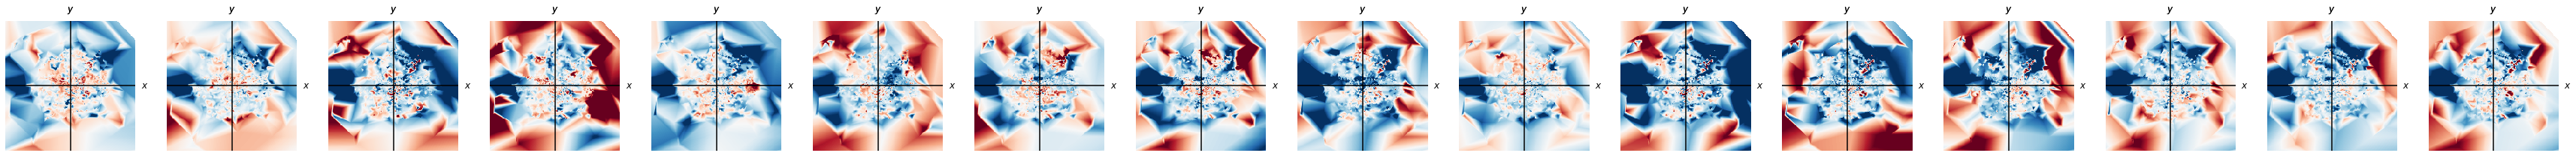

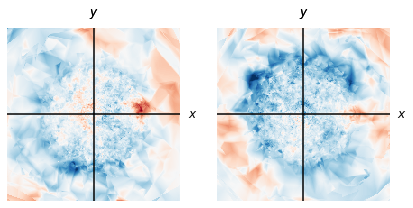

In [26]:
degs_lim = 12
interp_df = interpolate_activity(all_voxels[all_voxels.roi.isin([1])], conds, normalize=False, degs_lim = degs_lim, coords = 'cartesian')
ax_data = stim_activity_figure(interp_df, vmax = 1.5, degs_lim = degs_lim)
ax_data = avg_activity_figure(interp_df, vmax = 1.5, degs_lim = degs_lim)

Text(127.17647058823528, 0.5, 'Average')

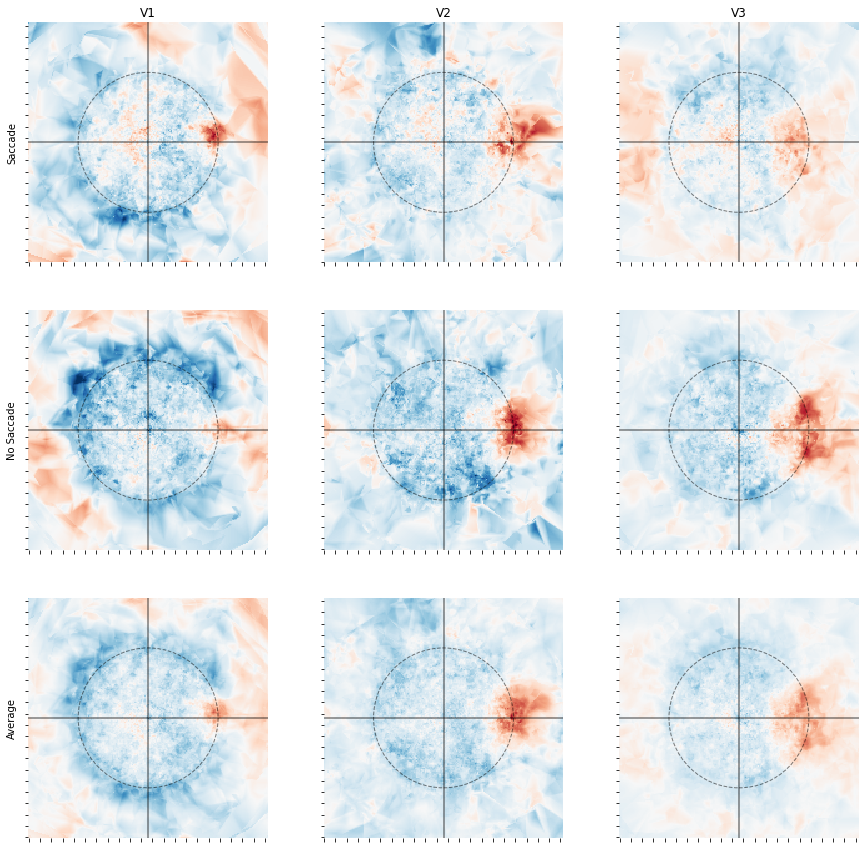

In [27]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
deg_stepsize = n_steps/degs_lim/2
stim_ecc = deg_stepsize * 7



for i in range(3):
    interp_df = interpolate_activity(all_voxels[all_voxels.roi.isin([i+1])], conds, normalize=False, degs_lim = degs_lim)
    dplot = interp_df.groupby(['sacc', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    
    nosacc = dplot[dplot.sacc == 0].activity_map_rot.values
    sacc = dplot[dplot.sacc == 1].activity_map_rot.values

    n_steps = len(np.arange(-degs_lim, degs_lim, 0.125))
    nosacc = np.reshape(nosacc, (n_steps, n_steps))
    sacc = np.reshape(sacc, (n_steps, n_steps))
    sn_avg = (sacc+nosacc)/2
    
    sns.heatmap(sacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0, vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[0, i])
    sns.heatmap(nosacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[1, i])
    sns.heatmap(sn_avg, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[2, i])
    
    

    for j in range(3):
        ax = axs[j, i]
        
        ecc_circle = plt.Circle((n_steps/2, n_steps/2), stim_ecc, color='black', fill=False, alpha = 0.5, linestyle = '--')
        ax.add_patch(ecc_circle)
        ax.set_xticklabels(labels=[], rotation=0)
        ax.set_yticklabels(labels=[])
        ax.axhline(y=n_steps/2, c="0", alpha = 0.5)
        ax.axvline(x=n_steps/2, c="0", alpha = 0.5)
        ax.invert_yaxis()
    
    
axs[0, 0].set_title('V1')
axs[0, 1].set_title('V2')
axs[0, 2].set_title('V3')

axs[0, 0].set_ylabel('Saccade')
axs[1, 0].set_ylabel('No Saccade')
axs[2, 0].set_ylabel('Average')

Text(108.05147058823528, 0.5, 'Average')

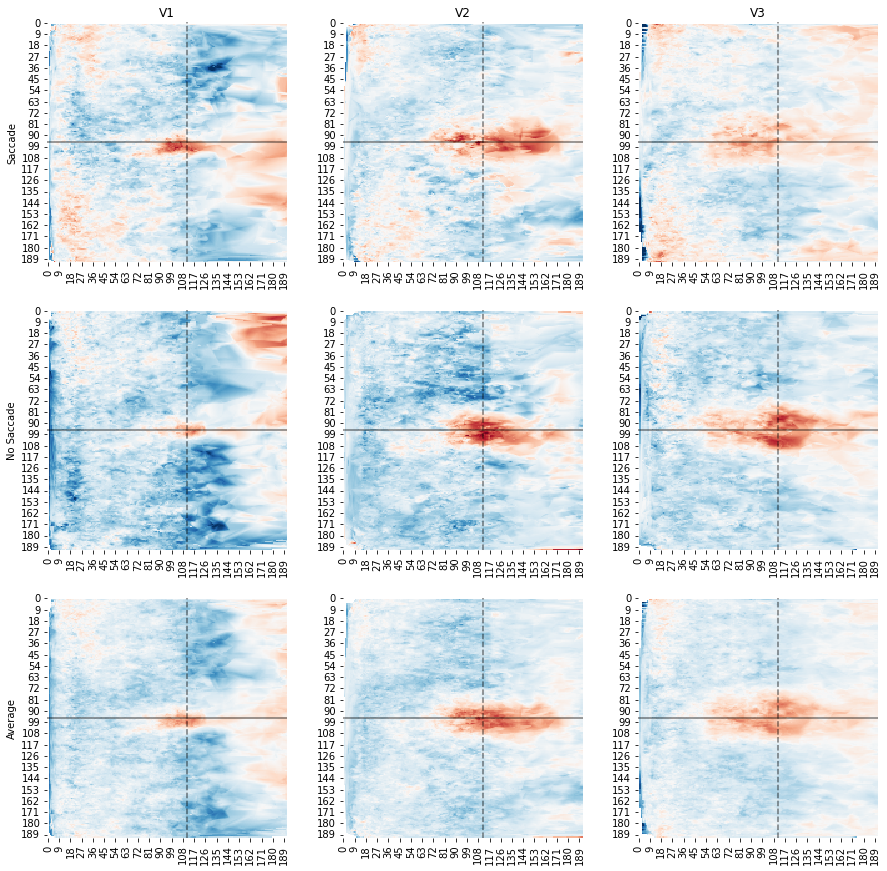

In [28]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
deg_stepsize = n_steps/degs_lim/2
stim_ecc = deg_stepsize * 7



for i in range(3):
    interp_df = interpolate_activity(all_voxels[all_voxels.roi.isin([i+1])], conds, normalize=False, degs_lim = degs_lim, coords = 'polar')
    dplot = interp_df.groupby(['sacc', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    
    nosacc = dplot[dplot.sacc == 0].activity_map_rot.values
    sacc = dplot[dplot.sacc == 1].activity_map_rot.values

    n_steps = len(np.arange(-degs_lim, degs_lim, 0.125))
    nosacc = np.reshape(nosacc, (n_steps, n_steps))
    sacc = np.reshape(sacc, (n_steps, n_steps))
    
    sn_avg = (sacc+nosacc)/2
    
    sns.heatmap(sacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0, vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[0, i])
    sns.heatmap(nosacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[1, i])
    sns.heatmap(sn_avg, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[2, i])
    
    

    for j in range(3):
        ax = axs[j, i]
        ax.axvline(x = stim_ecc*2, c = 'black', linestyle = '--', alpha = 0.5)
        ax.axhline(y = 192/2, c = 'black', alpha = 0.5)
    
    
axs[0, 0].set_title('V1')
axs[0, 1].set_title('V2')
axs[0, 2].set_title('V3')

axs[0, 0].set_ylabel('Saccade')
axs[1, 0].set_ylabel('No Saccade')
axs[2, 0].set_ylabel('Average')

Text(108.05147058823528, 0.5, 'Average')

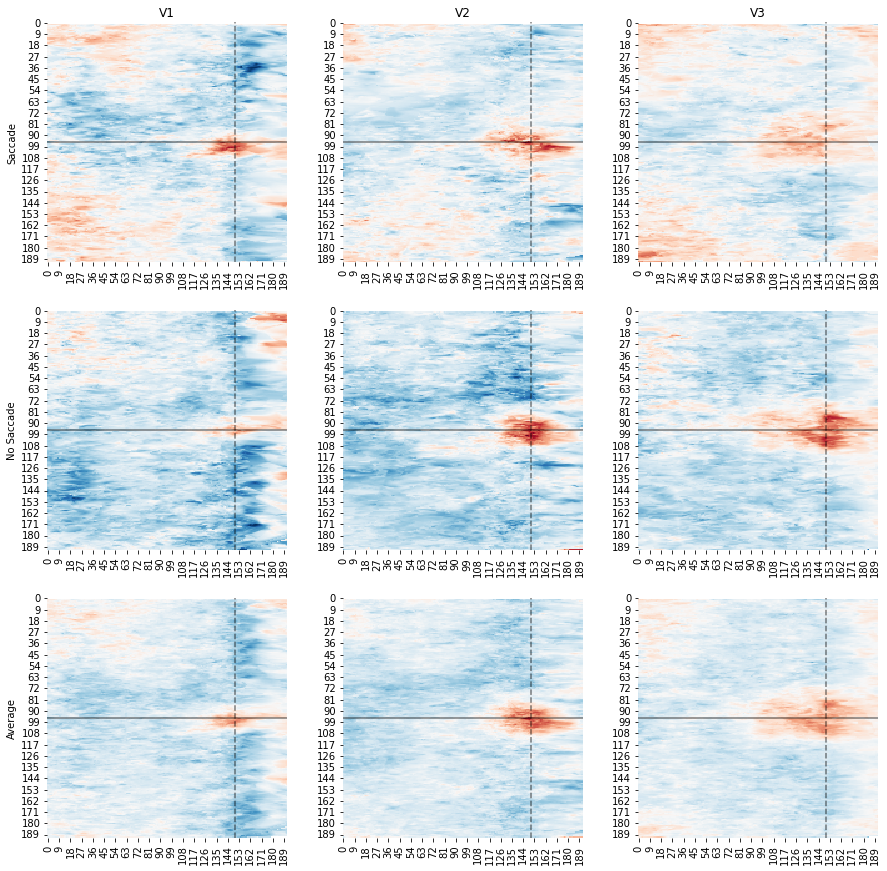

In [29]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
n_steps = 192
target = 7
stim_ecc = np.log(target+0.0001)/np.log(degs_lim + 0.0001) * n_steps




for i in range(3):
    interp_df = interpolate_activity(all_voxels[all_voxels.roi.isin([i+1])], conds, normalize=False, degs_lim = degs_lim, coords = 'logpolar')
    dplot = interp_df.groupby(['sacc', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    
    nosacc = dplot[dplot.sacc == 0].activity_map_rot.values
    sacc = dplot[dplot.sacc == 1].activity_map_rot.values

    n_steps = len(np.arange(-degs_lim, degs_lim, 0.125))
    nosacc = np.reshape(nosacc, (n_steps, n_steps))
    sacc = np.reshape(sacc, (n_steps, n_steps))
    
    sn_avg = (sacc+nosacc)/2
    
    sns.heatmap(sacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0, vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[0, i])
    sns.heatmap(nosacc, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[1, i])
    sns.heatmap(sn_avg, cbar=False, square=True, cmap='RdBu_r', linewidths=0,  vmin = -1.5, vmax = 1.5, cbar_kws={'ticks':[]}, ax = axs[2, i])  

    for j in range(3):
        ax = axs[j, i]
        ax.axvline(x = stim_ecc, c = 'black', linestyle = '--', alpha = 0.5)
        ax.axhline(y = 192/2, c = 'black', alpha = 0.5)
    
axs[0, 0].set_title('V1')
axs[0, 1].set_title('V2')
axs[0, 2].set_title('V3')

axs[0, 0].set_ylabel('Saccade')
axs[1, 0].set_ylabel('No Saccade')
axs[2, 0].set_ylabel('Average')

In [30]:
theta = np.linspace(-np.pi, np.pi, 361)
#l, k, s, k2, s2 = params.query("roi=='V1' & model=='perception'").iloc[0][['loc', 'kappa1', 'scale1', 'kappa2', 'scale2']]
yhat = diff_vonmises(theta, 0, 5, 2, 1, 2)

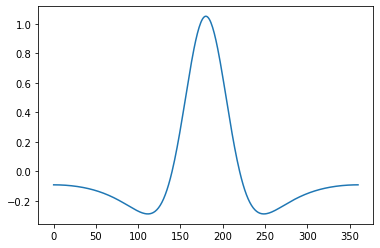

In [31]:
plt.plot(yhat)

In [32]:
conds

array([ 13.63915581,  25.58537477,  54.78592275,  73.13472389,
        93.39048424, 126.90172844, 151.22572819, 173.88219234,
       182.52315227, 214.88259873, 229.86144674, 252.62636113,
       284.75254118, 311.10459016, 316.4051996 , 359.08392416])

In [43]:
center_bin = lambda x: (x.left.astype(float) + x.right.astype(float))/2

def bin_ang_dists(voxels, conds, stim_ecc = 0, subj = ''):
    df = pd.DataFrame(columns = ['subj', 'roi', 'sacc', 'cond', 'stim_angle', 'ang_dist', 'ang_dist_bin', 'beta', 'vexpl'])
    # Restrict Eccentricit
    if stim_ecc:
        voxels = voxels[np.abs(stim_ecc - voxels.eccen) <= voxels.sigma]
    
    # Concatenate betas by position's distance from target stims
    for i, cond in enumerate(conds):
        sacc = 0
        if i < len(conds)/2: 
            sacc = 1
            
        if not subj:
            subj = voxels['subj']
            
        df = df.append(
            pd.DataFrame(
                {'subj': subj,
                 'roi': voxels['roi'],
                 'ang_dist': voxels['dist_cond%02d' % i], 
                 'beta': voxels['cond%02d' % i],
                 'vexpl': voxels['vexpl'],
                 'cond': i,
                 'stim_angle': cond,
                'sacc': sacc}
            ))
        
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(df['ang_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    df['ang_dist_bin'] = bins
    
    return df


def norm_group(voxels, yvar = 'beta', xvar = 'ang_dist_bin', group_cols = [], precision = False):
    # Take median of obs w/in each data group and distance bin
    group_cols = ['subj', 'roi', 'sacc'] + group_cols
    data = voxels.groupby(group_cols + [xvar]).median()[[yvar, 'vexpl']].reset_index()
    
    if precision:
        d = voxels.groupby(group_cols + [xvar])
        prec = []
        precvar = []
        for cols, g in d:
            pwm, pwv = precision_weighted_mean(g['beta'], g['vexpl'])
            prec.append(pwm)
            precvar.append(pwv)
        
        data['prec'] = prec
        data['precvar'] = precvar
    
    # Divide each subj response by norm
    norm_data = []
    for (cols, g) in data.groupby(group_cols):
        sd = g.copy()
        sd.loc[:, 'norm'] = np.linalg.norm(sd[yvar])
        sd.loc[:, yvar+'_norm'] = sd[yvar] / sd['norm']
        sd.loc[:, 'vexpl'] = sd['vexpl']
        
        if precision:
            sd.loc[:, 'precnorm'] = np.linalg.norm(sd['prec'])
            sd.loc[:, yvar + '_precnorm'] = sd['prec'] / sd['precnorm']
            sd.loc[:, 'precvar'] = sd['precvar']
        norm_data.append(sd)
    
    norm_data = pd.concat(norm_data)
    
    # Average across subjects and multiply by average norm to get units back
    norm_data = norm_data.groupby(group_cols[1:] + [xvar]).mean().reset_index()
    norm_data[yvar+'_adj'] = norm_data[yvar+'_norm']*norm_data['norm']
    if precision: norm_data[yvar+'_adj_prec'] = norm_data[yvar+'_precnorm']*norm_data['precnorm']

    
    return norm_data
    

def fit_diff_vonmises(data, yvar, xvar = 'ang_dist_bin', group_cols=[], drop_cols=[], precision = False):
    # convert dist bins to radians
    data[xvar+'_rad'] = data[xvar].apply(np.deg2rad)
    
    # Highly sampled x range in radians
    x = np.deg2rad(np.arange(-180, 180, 1))
    
    params = []
    assumed_cols = list(filter(lambda x: x not in drop_cols, ['roi', 'sacc']))
    
    for cols, g in data.groupby(assumed_cols + group_cols):
        try:
            bounds = [[-np.pi, 0, 0, 0, 0], [np.pi, np.inf, np.inf, np.inf, np.inf]]
            xbin = g[xvar+'_rad'].values
            ybin = g[yvar].values
            if precision: 
                sigma = np.sqrt(g['precvar'].values)
            else:
                sigma = None
            p_opt, p_cov = curve_fit(diff_vonmises, xbin, ybin, bounds=bounds, maxfev=10000, sigma = sigma)
            y_hat = diff_vonmises(x, *p_opt)
            loc, kappa1, scale1, kappa2, scale2 = p_opt
            
            width = fwhm(x, y_hat)
            
            # Return relevant params
            p = dict(func='diff_vonmises',
                     loc=loc,
                     loc_deg=np.rad2deg(loc),
                     kappa1=kappa1, 
                     scale1=scale1,
                     kappa2=kappa2,
                     scale2=scale2,
                     maxr=max(yhat),
                     minr=min(yhat),
                     amp=max(yhat)-min(yhat),
                     fwhm=width,
                     fwhm_deg=np.rad2deg(width)
                    )
        except:
            p = dict()
        
        group_df = g.reset_index()[assumed_cols + group_cols].iloc[:1]
        p = pd.DataFrame(p, index=[0])
        p = pd.concat([group_df, p], axis = 1)
        params.append(p)
        
    params = pd.concat(params, sort = False).reset_index(drop=True)
    
    return params

    


In [44]:
def precision_weighted_mean(x, var):
    x_mean = np.sum(x / var) / np.sum(1 / var)
    x_var = 1 / np.sum(1/var)

    
    return x_mean, x_var

1.9931704324630344


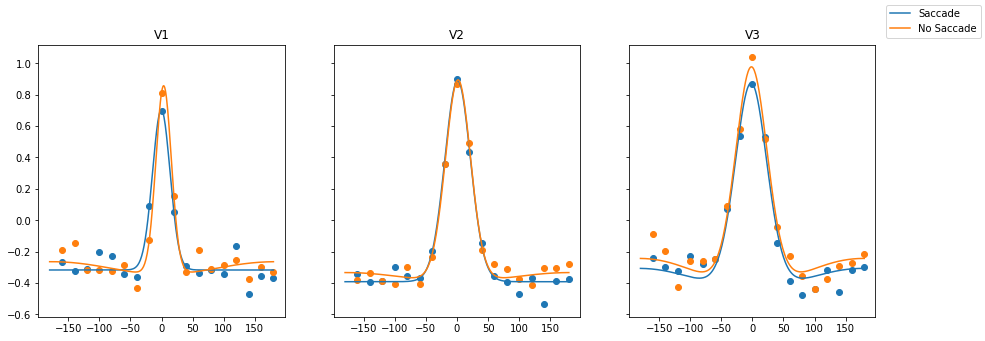

In [86]:
all_conds = np.concatenate([conds, conds])
roi_data = bin_ang_dists(all_voxels, all_conds, stim_ecc = 7, subj = 'wlsubj114')
norm_data = norm_group(roi_data, precision = True)

xval = 'beta_adj'
params_prec = fit_diff_vonmises(norm_data, xval, precision = True)

params_prec = params_prec.sort_values('sacc', ascending = False)

theta = np.linspace(-np.pi, np.pi, 361)
fig, axs = plt.subplots(1, 3, figsize = [15, 5], sharex=True, sharey=True)
for i, row in params_prec.iterrows():
    ax = axs[int(row.roi-1)]
    scatter_data = norm_data.query('roi == %d & sacc == %d' % (row.roi, row.sacc))
    
    ax.set_title('V%d' % row.roi)
    vm = diff_vonmises(theta, row['loc'], row.kappa1, row.scale1, row.kappa2, row.scale2)
    
    if row.sacc:
        s, = ax.plot(np.rad2deg(theta), vm, label = 'Saccade')
    else:
        n, = ax.plot(np.rad2deg(theta), vm, label = 'No Saccade')
    ax.scatter(scatter_data.ang_dist_bin, scatter_data[xval])

    
fig.legend(handles = [s, n])

print(np.linalg.norm(norm_data['beta_adj'] - norm_data['beta_adj_prec']))

In [77]:
xt = np.linspace(int(len(norm_data.beta_adj)/6/2), int(len(norm_data.beta_adj)) - int(len(norm_data.beta_adj)/6/2), 6, dtype = int)
list(xt)

[9, 27, 45, 63, 81, 99]

In [78]:
len(norm_data.beta_adj)/6

18.0

([<matplotlib.axis.XTick at 0x2b46a6aa0>,
 [Text(8, 0, 'V1 - No Sacc.'),
  Text(26, 0, 'V1 - Sacc.'),
  Text(44, 0, 'V2 - No Sacc.'),
  Text(62, 0, 'V2 - Sacc.'),
  Text(80, 0, 'V3 - No Sacc.'),
  Text(98, 0, 'V3 - Sacc.')])

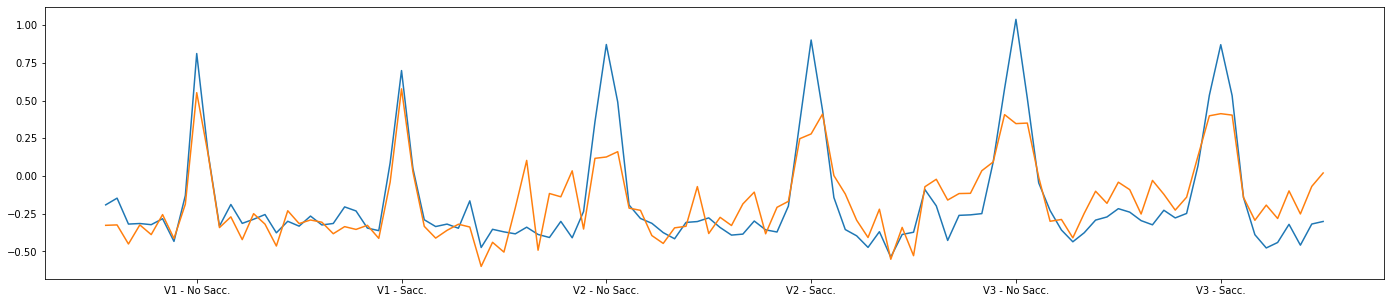

In [79]:
plt.plot(norm_data.beta_adj)
plt.plot(norm_data.beta_adj_prec)
plt.gcf().set_size_inches([24, 5])
plt.xticks(ticks = xt-1, labels = ['V1 - No Sacc.', 'V1 - Sacc.', 'V2 - No Sacc.', 'V2 - Sacc.', 'V3 - No Sacc.', 'V3 - Sacc.'])

In [37]:
norm_data

,roi,sacc,ang_dist_bin,beta,vexpl,prec,precvar,norm,beta_norm,precnorm,beta_precnorm,beta_adj,beta_adj_prec,ang_dist_bin_rad
0,1.0,0,-160.0,-0.292304,0.650203,-0.326817,0.000436,1.785294,-0.163729,1.472000,-0.222023,-0.292304,-0.326817,-2.792527
1,1.0,0,-140.0,-0.329296,0.655668,-0.324033,0.000439,1.785294,-0.184449,1.472000,-0.220131,-0.329296,-0.324033,-2.443461
2,1.0,0,-120.0,-0.501865,0.620262,-0.450458,0.000447,1.785294,-0.281110,1.472000,-0.306018,-0.501865,-0.450458,-2.094395
3,1.0,0,-100.0,-0.446869,0.650137,-0.323957,0.000476,1.785294,-0.250306,1.472000,-0.220079,-0.446869,-0.323957,-1.745329
4,1.0,0,-80.0,-0.437540,0.656921,-0.388234,0.000430,1.785294,-0.245080,1.472000,-0.263746,-0.437540,-0.388234,-1.396263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3.0,1,100.0,-0.433213,0.591500,-0.281583,0.000380,1.903149,-0.227630,0.984136,-0.286122,-0.433213,-0.281583,1.745329
104,3.0,1,120.0,-0.308334,0.561186,-0.098599,0.000342,1.903149,-0.162013,0.984136,-0.100188,-0.308334,-0.098599,2.094395
105,3.0,1,140.0,-0.495148,0.541301,-0.251338,0.000318,1.903149,-0.260173,0.984136,-0.255389,-0.495148,-0.251338,2.443461
106,3.0,1,160.0,-0.268023,0.590587,-0.068804,0.000399,1.903149,-0.140831,0.984136,-0.069914,-0.268023,-0.068804,2.792527


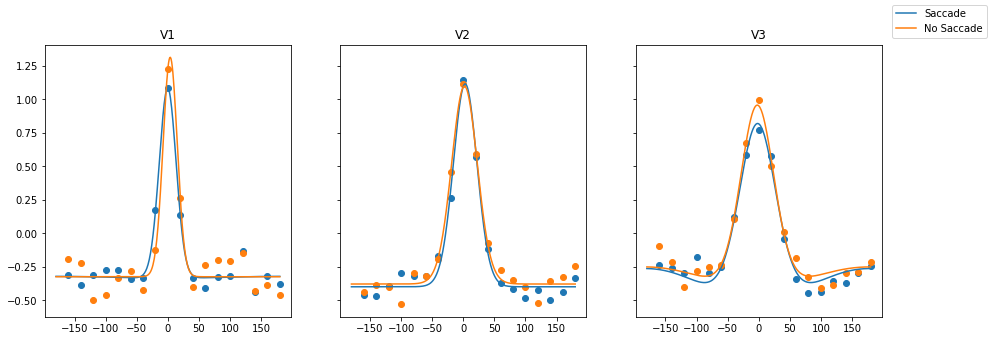

In [81]:
all_conds = np.concatenate([conds, conds])
roi_data = bin_ang_dists(all_voxels, all_conds, stim_ecc = 8, subj = 'wlsubj114')
norm_data = norm_group(roi_data)
params = fit_diff_vonmises(norm_data, 'beta_adj', precision = False)

params = params.sort_values('sacc', ascending = False)

theta = np.linspace(-np.pi, np.pi, 361)
fig, axs = plt.subplots(1, 3, figsize = [15, 5], sharex=True, sharey=True)
for i, row in params.iterrows():
    ax = axs[int(row.roi-1)]
    scatter_data = norm_data.query('roi == %d & sacc == %d' % (row.roi, row.sacc))
    
    ax.set_title('V%d' % row.roi)
    vm = diff_vonmises(theta, row['loc'], row.kappa1, row.scale1, row.kappa2, row.scale2)
    
    if row.sacc:
        s, = ax.plot(np.rad2deg(theta), vm, label = 'Saccade')
    else:
        n, = ax.plot(np.rad2deg(theta), vm, label = 'No Saccade')
    ax.scatter(scatter_data.ang_dist_bin, scatter_data.beta_adj)

    
fig.legend(handles = [s, n])

In [39]:
params

,roi,sacc,func,loc,loc_deg,kappa1,scale1,kappa2,scale2,maxr,minr,amp,fwhm,fwhm_deg
1,1.0,1,diff_vonmises,0.010664,0.610990,15.855106,0.781019,2.619484e-23,2.704049,1.050852,-0.289657,1.340509,0.436332,25.0
3,2.0,1,diff_vonmises,0.020554,1.177686,7.037281,1.400408,5.737192e-02,2.998602,1.050852,-0.289657,1.340509,0.663225,38.0
5,3.0,1,diff_vonmises,-0.048976,-2.806115,5.053604,1.864783,3.549297e-01,2.843217,1.050852,-0.289657,1.340509,0.767945,44.0
0,1.0,0,diff_vonmises,0.056685,3.247821,17.274699,0.821191,6.442004e-02,2.493292,1.050852,-0.289657,1.340509,0.418879,24.0
2,2.0,0,diff_vonmises,0.014611,0.837166,7.528750,1.334033,1.288305e-01,2.405150,1.050852,-0.289657,1.340509,0.663225,38.0
4,3.0,0,diff_vonmises,-0.043676,-2.502468,3.823334,2.083669,5.210227e-01,2.504516,1.050852,-0.289657,1.340509,0.890118,51.0


In [40]:
params_prec

,roi,sacc,func,loc,loc_deg,kappa1,scale1,kappa2,scale2,maxr,minr,amp,fwhm,fwhm_deg
1,1.0,1,diff_vonmises,0.010513,0.602366,15.843035,0.782773,1.475528e-18,2.714705,1.050852,-0.289657,1.340509,0.436332,25.0
3,2.0,1,diff_vonmises,0.021059,1.206572,7.113810,1.386436,4.414155e-02,2.993423,1.050852,-0.289657,1.340509,0.663225,38.0
5,3.0,1,diff_vonmises,-0.051524,-2.952104,5.079499,1.849656,3.444250e-01,2.841702,1.050852,-0.289657,1.340509,0.767945,44.0
0,1.0,0,diff_vonmises,0.056234,3.221996,17.104282,0.829297,7.278741e-02,2.514030,1.050852,-0.289657,1.340509,0.418879,24.0
2,2.0,0,diff_vonmises,0.017546,1.005286,7.521576,1.347508,1.469423e-01,2.447018,1.050852,-0.289657,1.340509,0.663225,38.0
4,3.0,0,diff_vonmises,-0.045229,-2.591404,3.818420,2.097133,5.332667e-01,2.509410,1.050852,-0.289657,1.340509,0.890118,51.0


In [15]:
wlsubj = 139
pos_dir = '~/mnt/winawer/Projects/Interstellar/task/Interstellar/training/positions/'

pos_filepath = os.path.join(pos_dir, "sub-wlsubj%03d_16pos.tsv" % wlsubj)
pd.read_csv(pos_filepath, sep = "\t", index_col = 0).degrees.values

array([ 20.82810177,  36.79261298,  59.40552772,  68.55875959,
        90.53752721, 126.74809475, 148.72611794, 177.13595113,
       186.97668395, 220.44054585, 239.35757718, 248.43300593,
       285.58450127, 308.9242211 , 335.57164003, 342.27830769,
         1.84993852,  32.13072436,  65.70331825,  88.03548896,
        94.22456644, 115.98574566, 156.14444294, 171.67428186,
       181.31867318, 213.3676929 , 240.22244905, 252.47699762,
       278.78626474, 314.96661454, 332.00708717, 340.17374885,
         5.15396302,  26.19816652,  54.53403779,  77.22221391,
       110.434527  , 134.17624834, 142.25256584, 172.64619368,
       201.06782922, 207.83612518, 246.6024886 , 255.04572729,
       285.78109534, 304.85847195, 331.35365954, 346.64864362])

NameError: name 'design_filenames' is not defined

In [ ]:
import itertools
import os.path as op
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import scipy.signal as sp
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import os
import pickle
import warnings
import seaborn as sns
from scipy.special import iv
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')

'''
PARAMETERS
'''
wlsubjects = [139]
glm_dir = '~/mnt/winawer/Projects/Interstellar/analyses/GLMsingle'
prf_dir = '~/mnt/winawer/Projects/Interstellar/analyses/prf_vista'
output_dir = '~/mnt/winawer/Projects/Interstellar/analyses/data'
pos_dir = '~/mnt/winawer/Projects/Interstellar/task/Interstellar/training/positions/'


ret_params = ['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl']
models = ['perception', 'ltm', 'wm']
space = 'surf'
load_hemis = ['lh', 'rh']
hemis = ['lh', 'rh', 'b']

stim_ecc = 7

'''
HELPER FUNCTIONS
'''
def load_retinotopy(subj_prf_directory, load_hemis, ret_params):
    ret = {p:{'lh':[], 'rh':[]} for p in ret_params}

    for hemi, param in itertools.product(load_hemis, ret_params):
        rfile = glob.glob(op.join(subj_prf_directory, '%s*%s.mgz') % (hemi, param))
        print(rfile)
        r = nib.load(rfile[0]).get_fdata().squeeze()
        ret[param][hemi].append(r)
    
    for param in ret_params:
        ret[param]['b'] = [np.concatenate(b) for b in zip(ret[param]['lh'], ret[param]['rh'])]
        
    return ret


    for wlsubj in wlsubjects:
        ret = load_retinotopy(
            os.path.join(prf_dir, "sub-wlsubj%03d" % wlsubj), load_hemis, ret_params)